## Top

In [78]:
import subprocess
import sys
import joblib
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm
from lightgbm import LGBMRegressor
import pandas as pd
import argparse
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import numpy as np
import boto3
import gc
import datetime as dt
import io
from io import StringIO
import os

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style="whitegrid")
# sns.set_context("notebook", font_scale=1.2)
# sns.set_palette(["lightblue"]) #lightblue

import shap
pd.set_option('display.max_columns', 100)

In [79]:
curr_dir = os.path.abspath(os.getcwd())
data_dir = os.path.join(curr_dir,'Data')
model_dir = os.path.join(curr_dir,'Models')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [80]:
prev_month = '2025-08-01'
current_month = '2025-09-01'

## Fetch Data

In [81]:
def read_data(model_date):
    filepath = f'KPIs_data_processed_{model_date}.csv'
    if not os.path.exists(os.path.join(data_dir, filepath)):
        import subprocess
        command = [
            "aws", "s3", "cp",
            f"s3://cbr-cohort-experiments/KPIs_Inference_Processed/{filepath}",
            "./Data/"
        ]
        
        subprocess.run(command, check=True)
    df = pd.read_csv(os.path.join(data_dir, filepath))
    return df
        

In [82]:
# df_prev_full = read_data(prev_month)
df = read_data(current_month)
df["reg_month"] = pd.to_datetime(df["reg_month"])
df.country.unique()

array(['Kenya', 'Myanmar (Burma)', 'Uganda', 'Nigeria', 'Tanzania',
       'India', 'Togo', 'Zambia', 'Mozambique', 'Cameroon', 'Malawi',
       'South Africa', 'Benin Republic'], dtype=object)

In [83]:
df

,accounts_group,reg_month,country,product_group,area,primary_product,count_units,avg_planned_repayment_days,total_follow_on_revenue_current_usd,total_follow_on_revenue,total_follow_on_revenue_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,age_in_months,exchange,total_follow_on_revenue_usd_cal,total_follow_on_revenue_usd_final,avg_upfront_price_usd,avg_unlock_price_usd,backtesting_limit,cohort_age_backtesting
0,2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-01-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,57,77,1543.400856,199500.0,1418.445741,0.352180,0.626566,0.785424,0.888827,0.924767,0.935544,0.945594,0.963138,0.964892,0.971333,1.0718,0.8275,0.7854,0.8888,0.9247,0.9355,0.9455,0.9631,0.9648,0.9713,1.0,5.0,11.0,25.0,33.0,42.0,43.0,51.0,57.0,69.0,0.181818,0.080000,0.148148,0.125000,0.222222,0.250000,0.333333,0.166667,0.200000,0.333333,0.017544,0.122807,0.175439,0.157895,0.157895,0.105263,0.105263,0.087719,0.087719,0.052632,0.035088,0.122807,0.526316,0.719298,0.842105,0.859649,0.894737,0.894737,0.912281,0.947368,0.263158,0.315789,0.368421,0.228070,0.157895,0.122807,0.105263,0.105263,0.087719,0.052632,115,152.85,1305.2012,1305.201200,7.0,30.0,30,30
1,2016-02_Kenya_Lanterns_Bungoma_Sun King Pro Ea...,2016-02-01,Kenya,Lanterns,Bungoma,Sun King Pro EasyBuy,18,77,487.389744,63000.0,447.930234,0.425714,0.686587,0.807381,0.849048,0.856984,0.856984,0.856984,0.856984,0.892698,0.903810,1.2956,0.9068,0.8073,0.8490,0.8569,0.8569,0.8569,0.8569,0.8926,0.9038,0.0,3.0,8.0,14.0,14.0,14.0,14.0,14.0,102.0,105.0,0.055556,0.062500,0.090909,0.166667,0.166667,0.166667,0.166667,0.166667,0.250000,1.000000,0.000000,0.111111,0.277778,0.333333,0.333333,0.333333,0.333333,0.333333,0.166667,0.055556,0.000000,0.111111,0.388889,0.666667,0.666667,0.666667,0.666667,0.666667,0.777778,0.833333,0.277778,0.388889,0.444444,0.333333,0.333333,0.333333,0.333333,0.333333,0.222222,0.055556,114,152.85,412.1688,412.168800,7.0,30.0,30,30
2,2016-02_Kenya_Lanterns_Kakamega_Sun King Pro E...,2016-02-01,Kenya,Lanterns,Kakamega,Sun King Pro EasyBuy,287,77,7771.158696,1004500.0,7141.998731,0.365668,0.618819,0.763085,0.867551,0.897489,0.917509,0.924428,0.933954,0.938175,0.951517,1.1129,0.8173,0.7630,0.8675,0.8974,0.9175,0.9244,0.9339,0.9381,0.9515,1.0,7.0,13.0,32.0,43.0,55.0,63.0,72.0,80.0,90.0,0.156364,0.113725,0.130435,0.166667,0.196721,0.224490,0.244444,0.263158,0.272727,0.200000,0.045296,0.087108,0.198606,0.205575,0.163763,0.139373,0.132404,0.114983,0.101045,0.059233,0.041812,0.111498,0.439024,0.707317,0.787456,0.829268,0.843206,0.867596,0.878049,0.909408,0.229965,0.341463,0.386760,0.268293,0.188153,0.163763,0.153310,0.128920,0.108014,0.062718,114,152.85,6571.8024,6571.802400,7.0,30.0,30

In [84]:
# df = df[(df.country.isin(['Kenya', 'Nigeria', 'Tanzania'])) & (df.cohort_age_backtesting==450)]
# cols = [i for i in df.columns if "540" not in i and "630" not in i and "720" not in i]
# df = df[cols]

In [85]:
df = df[(df.country.isin(['Kenya', 'Nigeria', 'Tanzania']))  & (df.backtesting_limit==360)]

In [86]:
frr_cols = [c for c in df.columns if c.startswith("frr_")]
print("FRR columns:", frr_cols)

FRR columns: ['frr_30', 'frr_60', 'frr_90', 'frr_180', 'frr_270', 'frr_360', 'frr_450', 'frr_540', 'frr_630', 'frr_720']


## FRR Gain from 360 to 450

/tmp/ipykernel_5469/3548290115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff_frr_450_360"] = df["frr_450"] - df["frr_360"]


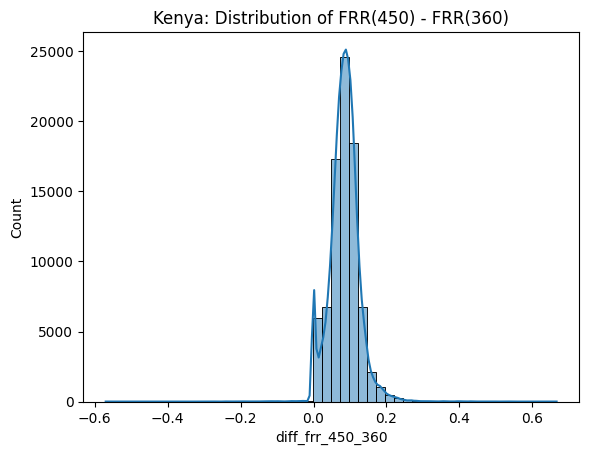

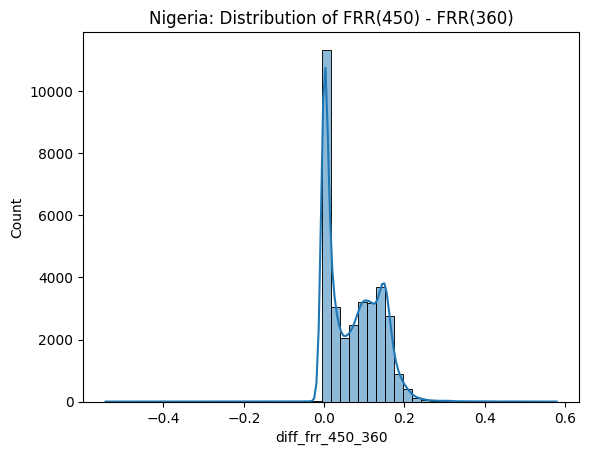

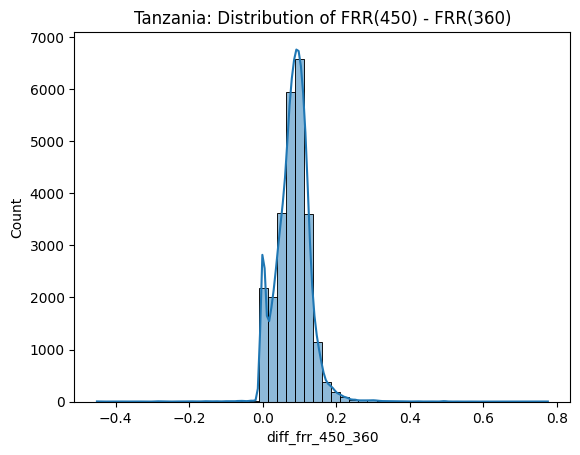

In [87]:
df["diff_frr_450_360"] = df["frr_450"] - df["frr_360"]
for country in df.country.unique():
    sns.histplot(df[df.country==country]["diff_frr_450_360"].dropna(), bins=50, kde=True)
    plt.title(f"{country}: Distribution of FRR(450) - FRR(360)")
    plt.show()

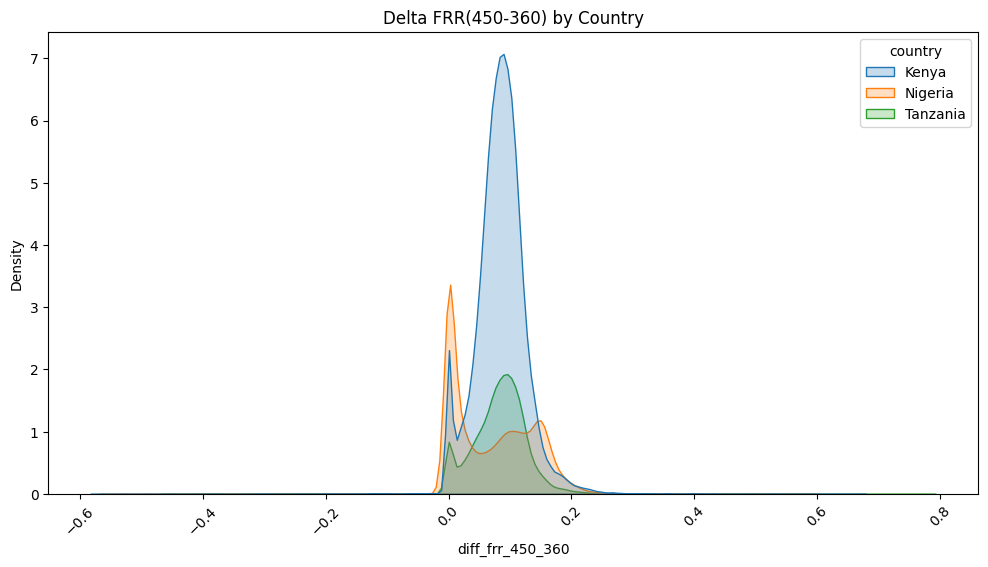

In [88]:
plt.figure(figsize=(12,6))
# sns.boxplot(data=df, x="country", y="diff_frr_450_360")
sns.kdeplot(data=df, x="diff_frr_450_360", hue='country', fill=True)
plt.title("Delta FRR(450-360) by Country")
plt.xticks(rotation=45)
plt.show()

## Distplot for FRR

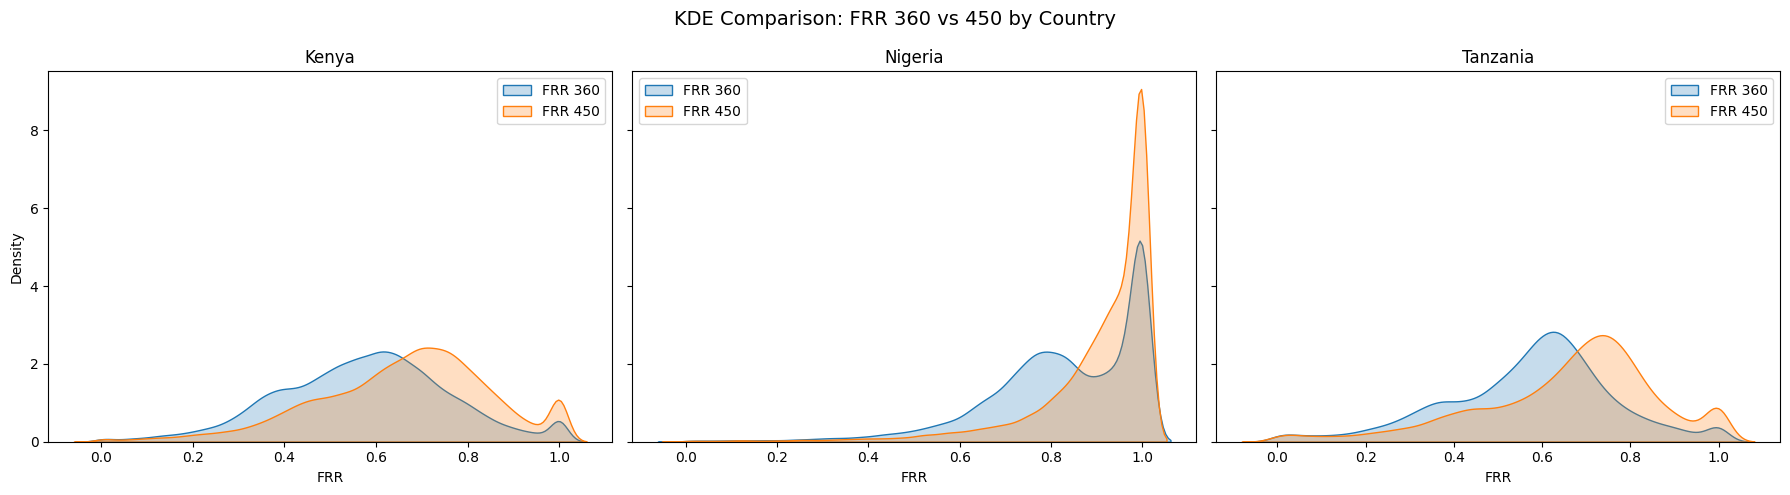

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

countries = df["country"].unique()
fig, axes = plt.subplots(1, len(countries), figsize=(18, 5), sharey=True)

for ax, country in zip(axes, countries):
    subset = df[df["country"] == country]
    sns.kdeplot(subset["frr_360"], label="FRR 360", ax=ax, fill=True)
    sns.kdeplot(subset["frr_450"], label="FRR 450", ax=ax, fill=True)
    
    ax.set_title(f"{country}")
    ax.set_xlabel("FRR")
    ax.set_ylabel("Density")
    ax.legend()

plt.suptitle("KDE Comparison: FRR 360 vs 450 by Country", fontsize=14)
plt.tight_layout()
plt.show()


 ## Distplots for Main KPIs

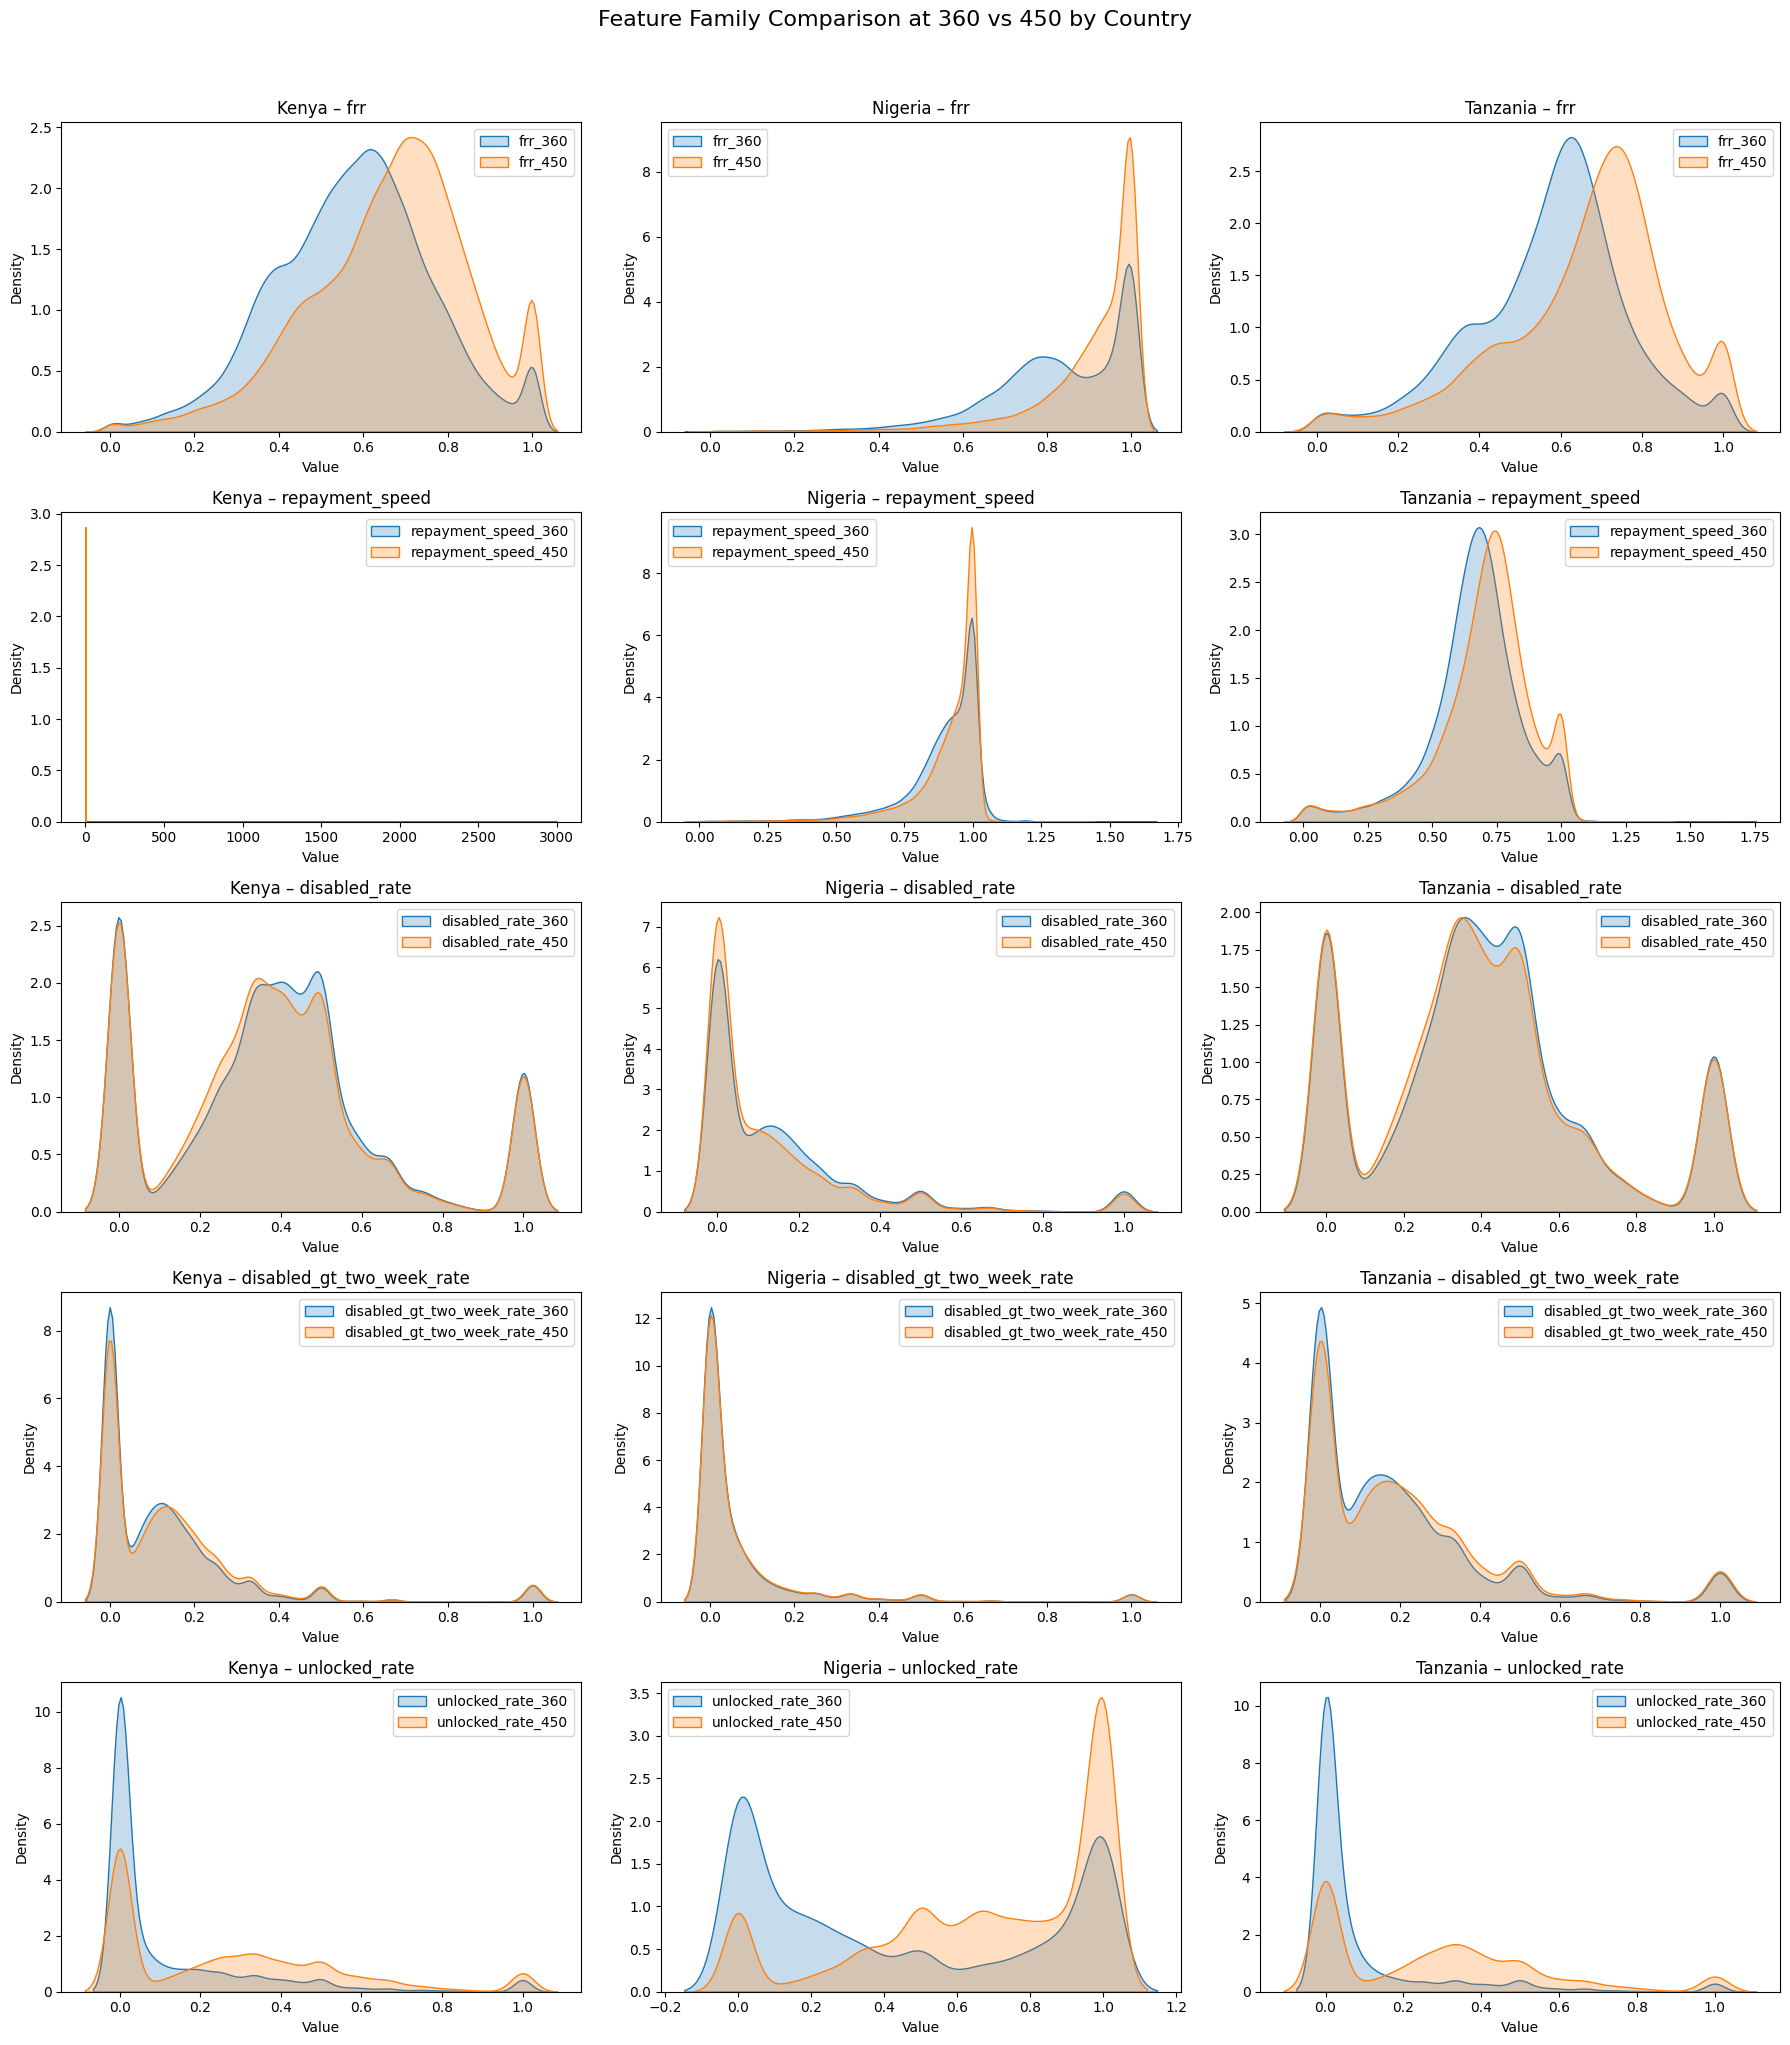

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

feature_families = [
    "frr",
    "repayment_speed",
    # "at_risk_rate",
    "disabled_rate",
    "disabled_gt_two_week_rate",
    "unlocked_rate",
    # "avg_cum_days_disabled"
]

countries = df["country"].unique()
n_rows = len(feature_families)
fig, axes = plt.subplots(n_rows, len(countries), figsize=(6*len(countries), 4*n_rows), sharey=False)

if n_rows == 1:
    axes = [axes]

for i, family in enumerate(feature_families):
    for j, country in enumerate(countries):
        ax = axes[i, j] if n_rows > 1 else axes[j]
        
        subset = df[df["country"] == country]
        col_360 = f"{family}_360"
        col_450 = f"{family}_450"
        
        sns.kdeplot(subset[col_360], label=f"{family}_360", ax=ax, fill=True)
        sns.kdeplot(subset[col_450], label=f"{family}_450", ax=ax, fill=True)
        
        ax.set_title(f"{country} – {family}")
        ax.set_xlabel("Value")
        ax.legend()

plt.suptitle("Feature Family Comparison at 360 vs 450 by Country", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
plt.close()


In [91]:
frr_cols = [i for i in df.columns if i.startswith("frr_")]

## Corr of FRR Cols

<Axes: >

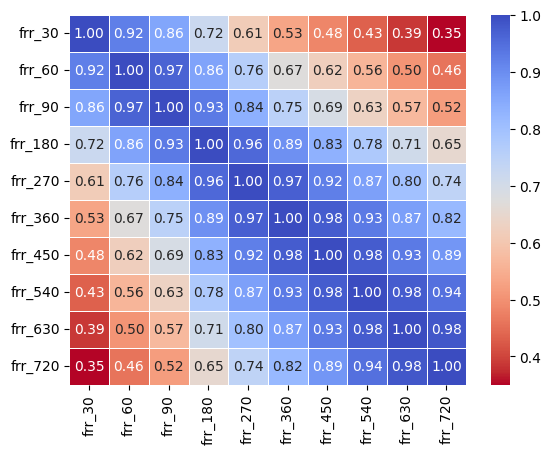

In [92]:
sns.heatmap(df[df.country=="Kenya"][frr_cols].corr(), annot=True, cmap="coolwarm_r", fmt=".2f", linewidths=0.5)

<Axes: >

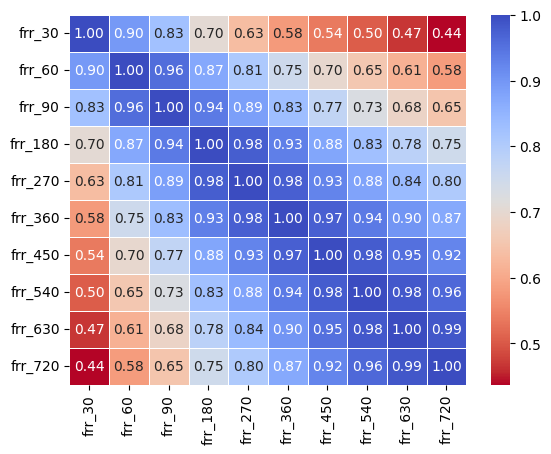

In [93]:
sns.heatmap(df[df.country=="Tanzania"][frr_cols].corr(), annot=True, cmap="coolwarm_r", fmt=".2f", linewidths=0.5)

<Axes: >

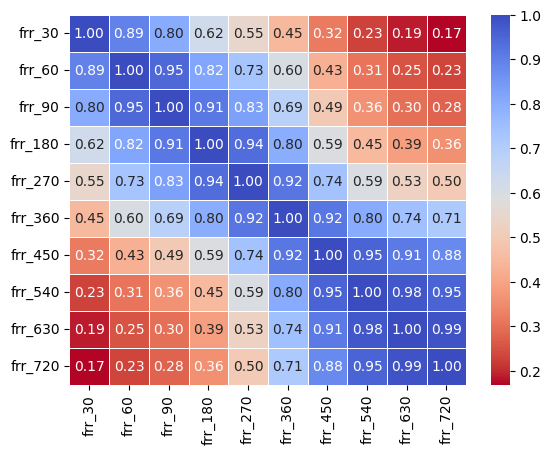

In [94]:
sns.heatmap(df[df.country=="Nigeria"][frr_cols].corr(), annot=True, cmap="coolwarm_r", fmt=".2f", linewidths=0.5)

In [95]:
# repay_cols = [c for c in df.columns if c.startswith("repayment_speed")]
# sns.heatmap(df[df.country=="Nigeria"][repay_cols+["frr_450"]].corr(), annot=True, cmap="coolwarm_r", fmt=".2f", linewidths=0.5)


## FRR Gain

In [96]:
df[["country", "diff_frr_450_360"]+frr_cols].groupby("country").agg(
    mean_frr360=("frr_360", "mean"),
    mean_frr450=("frr_450", "mean"),
    median_frr360=("frr_360", "median"),
    median_frr450=("frr_450", "median"),
    mean_diff_frr_450_360=("diff_frr_450_360", "mean")

).reset_index()

,country,mean_frr360,mean_frr450,median_frr360,median_frr450,mean_diff_frr_450_360
0,Kenya,0.574162,0.659350,0.581122,0.681230,0.084555
1,Nigeria,0.826447,0.902005,0.846139,0.951237,0.071366
2,Tanzania,0.571920,0.657262,0.595548,0.696132,0.082407


## FRR across UADs
On Looker: https://greenlightplanet.looker.com/explore/Specialist/portfolio_full?qid=zHVy02MpjhQTz3vvCfqvRd&toggle=dat,vis

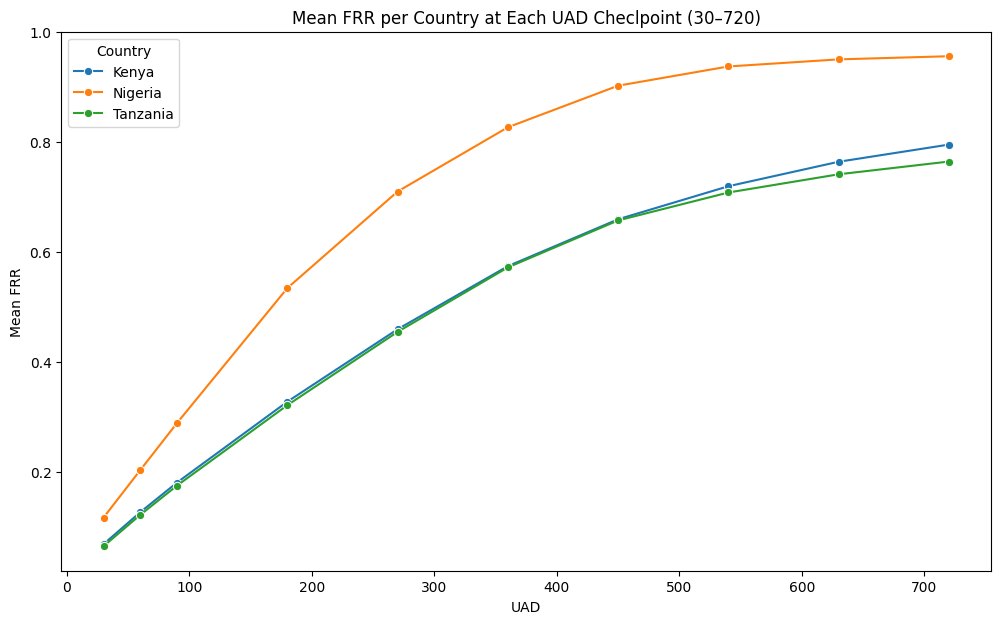

In [97]:
frr_cols = [c for c in df.columns if c.startswith("frr_")]
df_melt = df.melt(id_vars=["country"], value_vars=frr_cols,
                  var_name="horizon", value_name="frr")
df_melt["horizon"] = df_melt["horizon"].str.extract(r"(\d+)").astype(int)

country_mean = df_melt.groupby(["country", "horizon"])["frr"].mean().reset_index()
plt.figure(figsize=(12,7))
sns.lineplot(data=country_mean, x="horizon", y="frr", hue="country", marker="o")
plt.title("Mean FRR per Country at Each UAD Checlpoint (30–720)")
plt.xlabel("UAD")
plt.ylabel("Mean FRR")
plt.legend(title="Country")
plt.show()

## Unlock Rate Across UADs

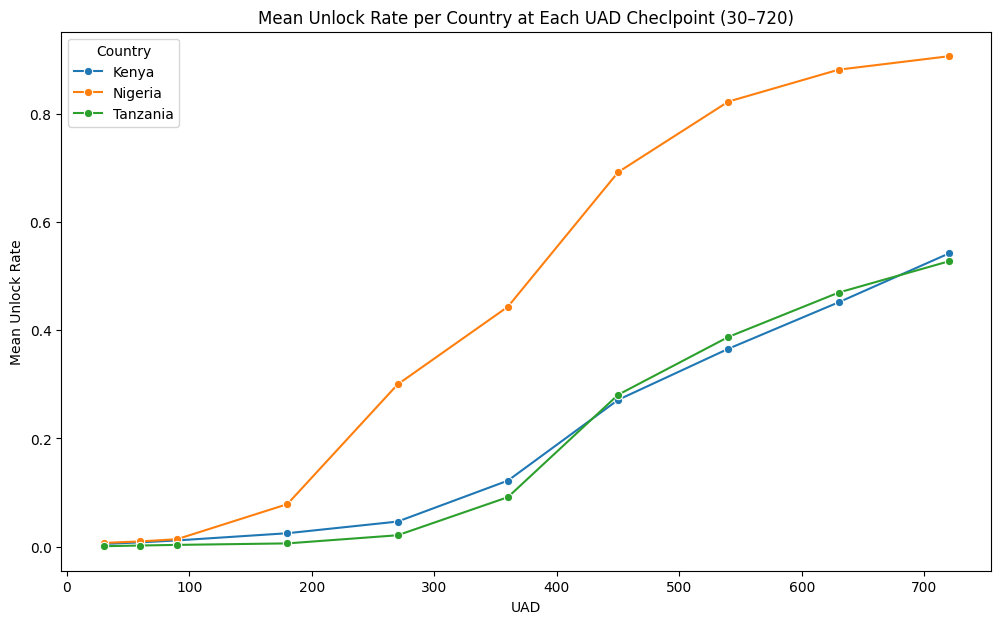

In [98]:
unlock_cols = [c for c in df.columns if c.startswith("unlocked_rate")]
df_unlock = df.melt(id_vars=["country"], value_vars=unlock_cols,
                    var_name="horizon", value_name="unlock_rate")
df_unlock["horizon"] = df_unlock["horizon"].str.extract(r"(\d+)").astype(int)
country_unlock_mean = df_unlock.groupby(["country", "horizon"])["unlock_rate"].mean().reset_index()

plt.figure(figsize=(12,7))
sns.lineplot(data=country_unlock_mean, x="horizon", y="unlock_rate", hue="country", marker="o")
plt.title("Mean Unlock Rate per Country at Each UAD Checlpoint (30–720)")
plt.xlabel("UAD")
plt.ylabel("Mean Unlock Rate")
plt.legend(title="Country")
plt.show()



In [99]:
df[df.accounts_group=='2024-02_Kenya_Lanterns_Bungoma_Sun King Boom EasyBuy']

,accounts_group,reg_month,country,product_group,area,primary_product,count_units,avg_planned_repayment_days,total_follow_on_revenue_current_usd,total_follow_on_revenue,total_follow_on_revenue_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,age_in_months,exchange,total_follow_on_revenue_usd_cal,total_follow_on_revenue_usd_final,avg_upfront_price_usd,avg_unlock_price_usd,backtesting_limit,cohort_age_backtesting,diff_frr_450_360
1189596,2024-02_Kenya_Lanterns_Bungoma_Sun King Boom E...,2024-02-01,Kenya,Lanterns,Bungoma,Sun King Boom EasyBuy,1488,407,93189.153164,12045630.0,78806.86847,0.062308,0.11602,0.164715,0.298938,0.423523,0.538398,0.640187,0.70215,NaN,NaN,0.934,0.8238,0.7644,0.6839,0.6425,0.6109,0.6401,0.7021,NaN,NaN,3.0,10.0,18.0,47.0,78.0,112.0,146.0,177.0,NaN,NaN,0.122984,0.025886,0.015089,0.006901,0.005559,0.005602,0.006494,0.008056,NaN,NaN,0.010753,0.023522,0.034274,0.070565,0.108199,0.138441,0.162634,0.194892,NaN,NaN,0.0,0.0,0.000672,0.002016,0.00336,0.009409,0.139113,0.296371,NaN,NaN,0.236559,0.290323,0.344758,0.396505,0.438844,0.442204,0.476478,0.440188,NaN,NaN,18,152.85,78806.8695,78806.86847,3.0,56.0,360,540,0.101789


In [100]:
df[df.accounts_group=='2023-02_Kenya_Lanterns_Bungoma_Sun King Boom EasyBuy']

,accounts_group,reg_month,country,product_group,area,primary_product,count_units,avg_planned_repayment_days,total_follow_on_revenue_current_usd,total_follow_on_revenue,total_follow_on_revenue_usd,frr_30,frr_60,frr_90,frr_180,frr_270,frr_360,frr_450,frr_540,frr_630,frr_720,repayment_speed_30,repayment_speed_60,repayment_speed_90,repayment_speed_180,repayment_speed_270,repayment_speed_360,repayment_speed_450,repayment_speed_540,repayment_speed_630,repayment_speed_720,avg_cum_days_disabled_30,avg_cum_days_disabled_60,avg_cum_days_disabled_90,avg_cum_days_disabled_180,avg_cum_days_disabled_270,avg_cum_days_disabled_360,avg_cum_days_disabled_450,avg_cum_days_disabled_540,avg_cum_days_disabled_630,avg_cum_days_disabled_720,at_risk_rate_30,at_risk_rate_60,at_risk_rate_90,at_risk_rate_180,at_risk_rate_270,at_risk_rate_360,at_risk_rate_450,at_risk_rate_540,at_risk_rate_630,at_risk_rate_720,disabled_gt_two_week_rate_30,disabled_gt_two_week_rate_60,disabled_gt_two_week_rate_90,disabled_gt_two_week_rate_180,disabled_gt_two_week_rate_270,disabled_gt_two_week_rate_360,disabled_gt_two_week_rate_450,disabled_gt_two_week_rate_540,disabled_gt_two_week_rate_630,disabled_gt_two_week_rate_720,unlocked_rate_30,unlocked_rate_60,unlocked_rate_90,unlocked_rate_180,unlocked_rate_270,unlocked_rate_360,unlocked_rate_450,unlocked_rate_540,unlocked_rate_630,unlocked_rate_720,disabled_rate_30,disabled_rate_60,disabled_rate_90,disabled_rate_180,disabled_rate_270,disabled_rate_360,disabled_rate_450,disabled_rate_540,disabled_rate_630,disabled_rate_720,age_in_months,exchange,total_follow_on_revenue_usd_cal,total_follow_on_revenue_usd_final,avg_upfront_price_usd,avg_unlock_price_usd,backtesting_limit,cohort_age_backtesting,diff_frr_450_360
1147744,2023-02_Kenya_Lanterns_Bungoma_Sun King Boom E...,2023-02-01,Kenya,Lanterns,Bungoma,Sun King Boom EasyBuy,970,368,54781.06137,7081000.0,56368.41205,0.067196,0.12186,0.17007,0.309254,0.443432,0.567962,0.670312,0.730355,0.771733,0.800239,0.9083,0.7803,0.7135,0.6377,0.6061,0.5806,0.6703,0.7303,0.7717,0.8002,3.0,11.0,21.0,57.0,92.0,128.0,162.0,192.0,218.0,240.0,0.150671,0.055728,0.026943,0.011435,0.008368,0.008484,0.010568,0.013201,0.015686,0.023599,0.013402,0.035052,0.053608,0.075258,0.098969,0.146392,0.175258,0.194845,0.198969,0.106186,0.001031,0.001031,0.001031,0.002062,0.005155,0.017526,0.208247,0.358763,0.456701,0.52268,0.259794,0.369072,0.440206,0.384536,0.472165,0.476289,0.481443,0.424742,0.393814,0.254639,30,152.85,46326.4639,46326.4639,4.0,52.0,360,720,0.10235


## FRR across Registration Month

FRR Looker link for more filtering: https://greenlightplanet.looker.com/explore/Specialist/portfolio_full?qid=60o0fCNPkSjrsuzrrYRrJs&toggle=dat,vis 

RS in Looker: https://greenlightplanet.looker.com/explore/Specialist/portfolio_full?qid=AQPYdzTPkrFpbkQxkB2rn4&toggle=dat,vis

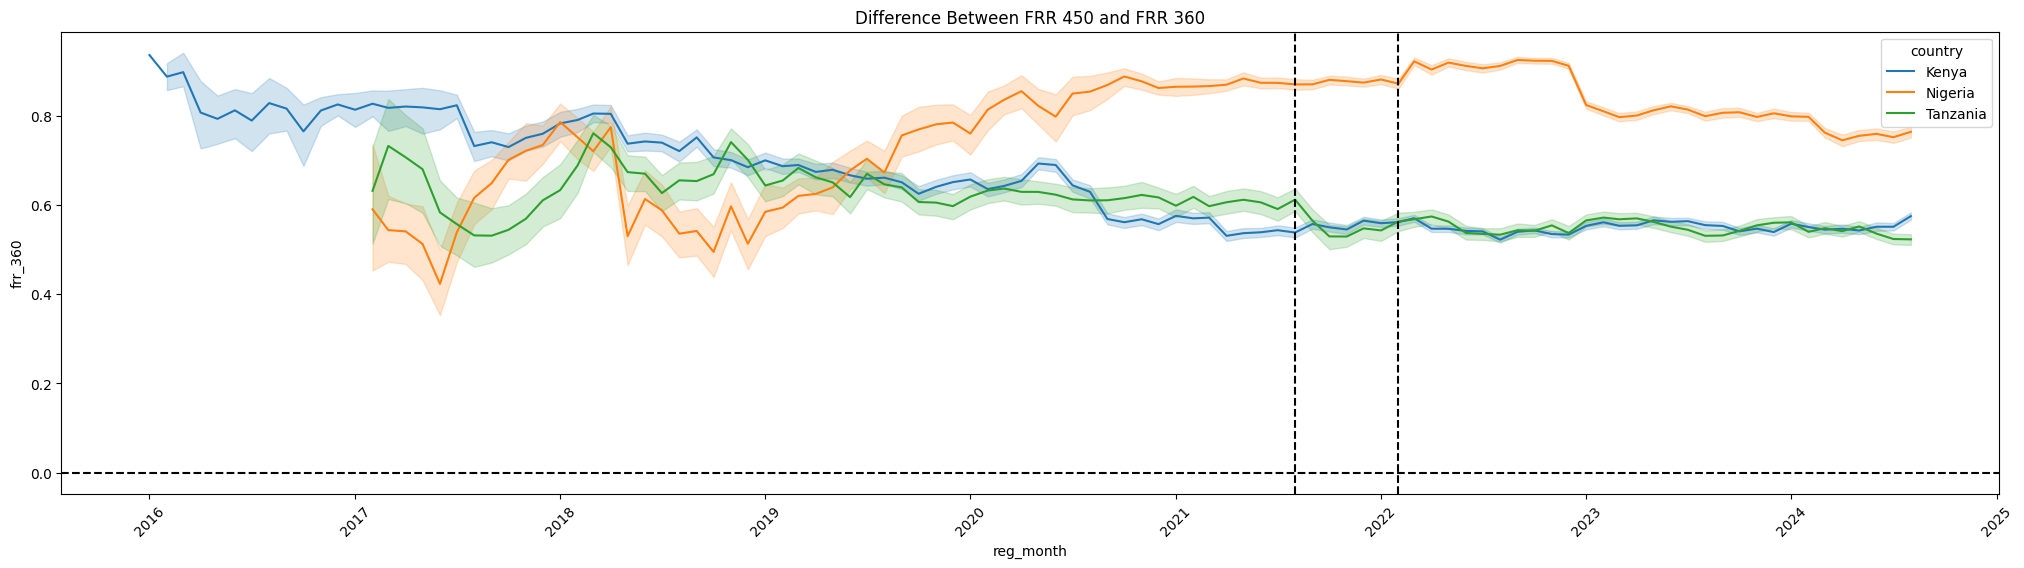

In [ ]:


sns.lineplot(data=df, x="reg_month", y="frr_360", hue="country")
plt.axhline(0, color="black", linestyle="--")
plt.axvline(pd.to_datetime("2022-02"), color="black", linestyle="--")
plt.axvline(pd.to_datetime("2021-08"), color="black", linestyle="--")
plt.xticks(rotation=45)
plt.title("FRR 360")
plt.show()

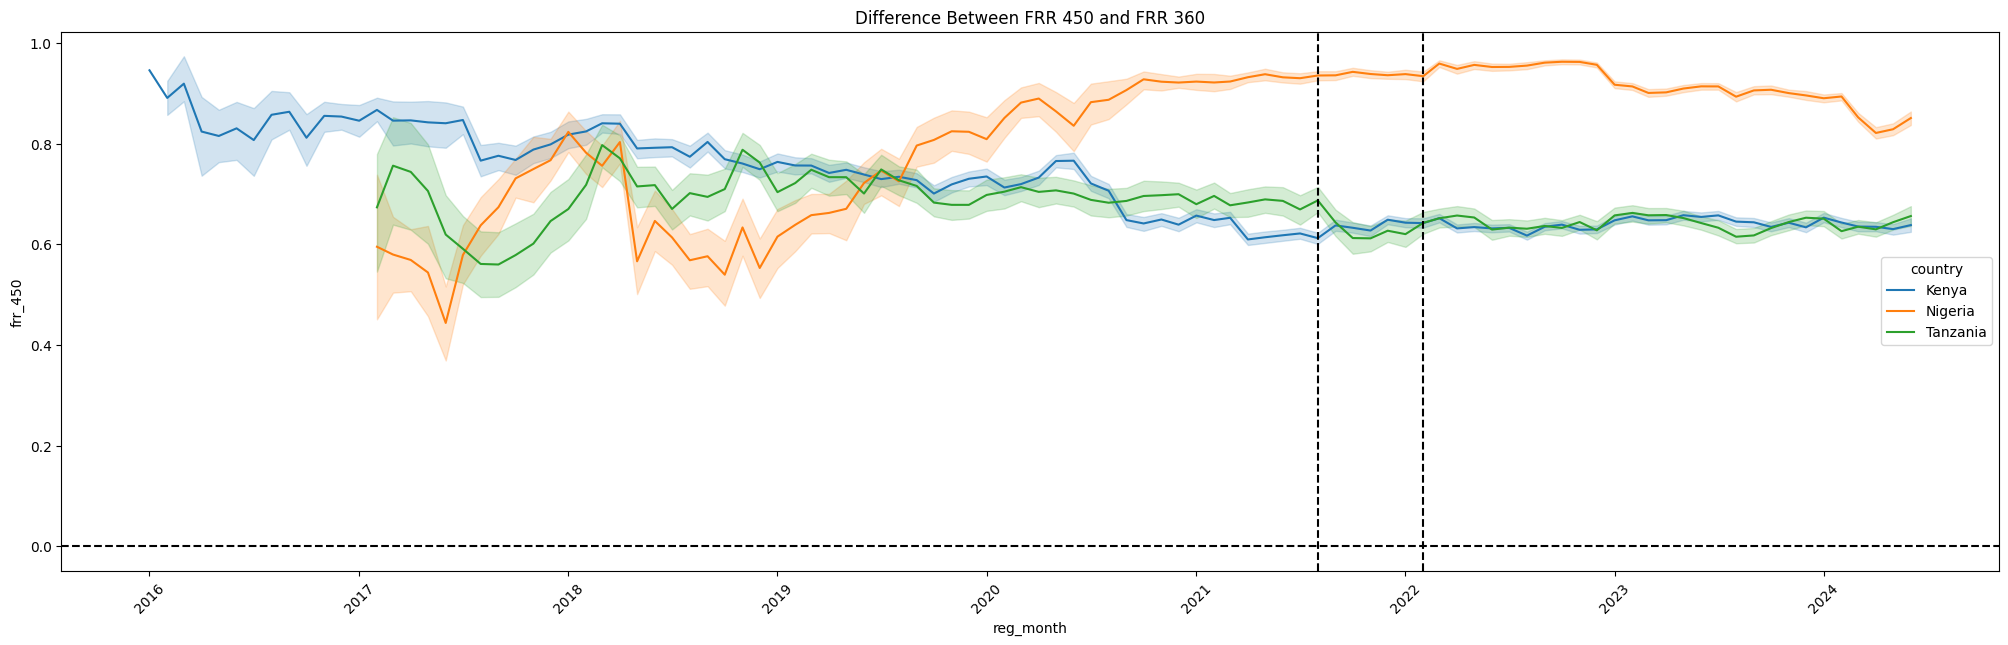

In [ ]:
plt.figure(figsize=(25, 7))
sns.lineplot(data=df, x="reg_month", y="frr_450", hue="country")
plt.axhline(0, color="black", linestyle="--")
plt.axvline(pd.to_datetime("2022-02"), color="black", linestyle="--")
plt.axvline(pd.to_datetime("2021-08"), color="black", linestyle="--")
plt.xticks(rotation=45)
plt.title("FRR 450")
plt.show()

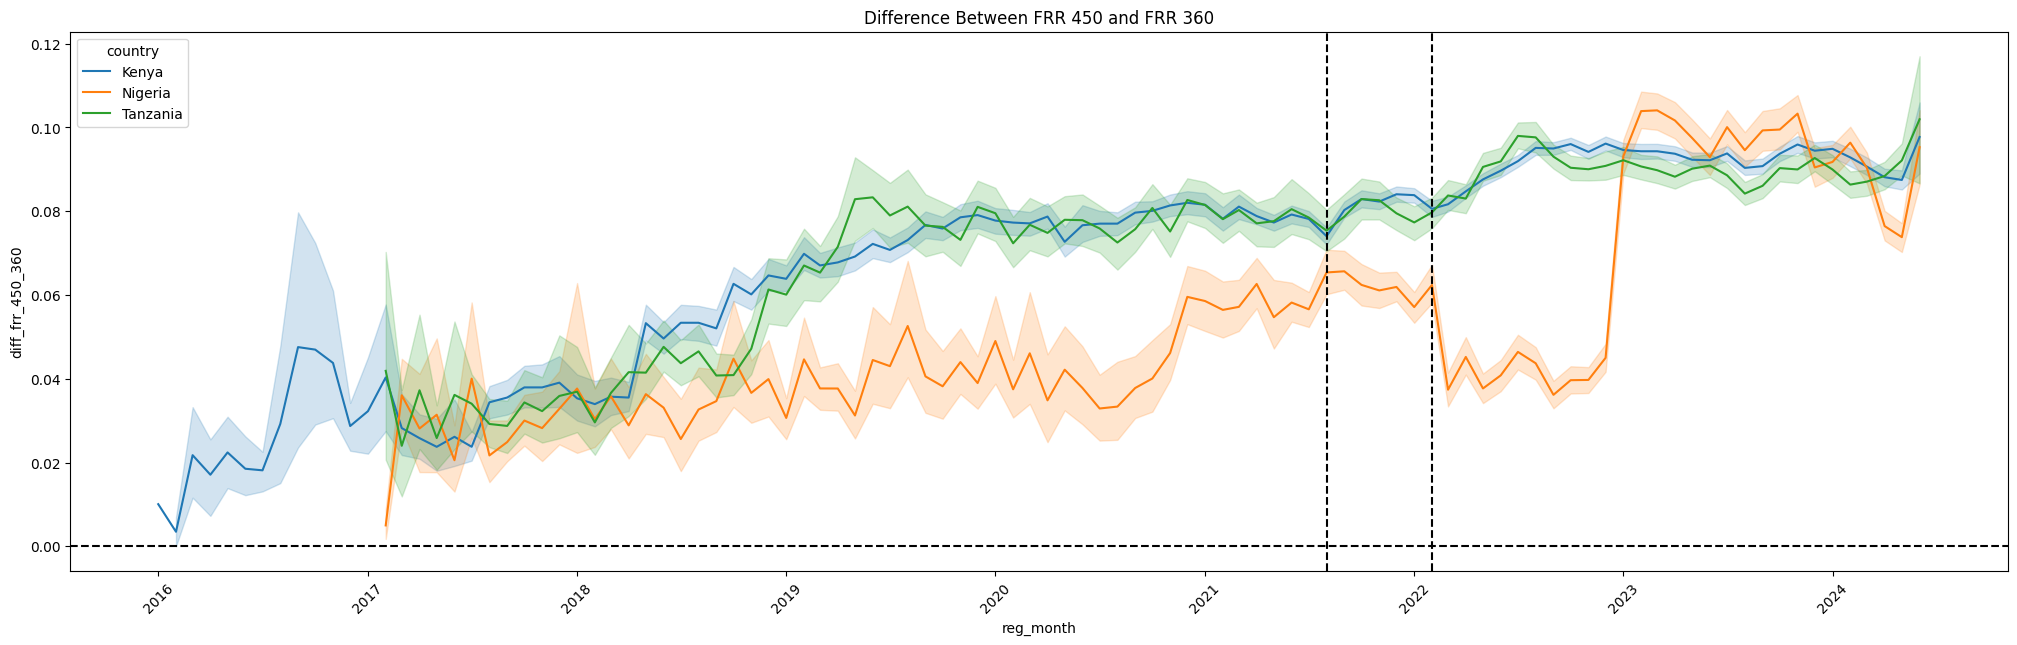

In [103]:
plt.figure(figsize=(25, 7))
sns.lineplot(data=df, x="reg_month", y="diff_frr_450_360", hue="country")
plt.axhline(0, color="black", linestyle="--")
plt.axvline(pd.to_datetime("2022-02"), color="black", linestyle="--")
plt.axvline(pd.to_datetime("2021-08"), color="black", linestyle="--")
plt.xticks(rotation=45)
plt.title("Difference Between FRR 450 and FRR 360")
plt.show()

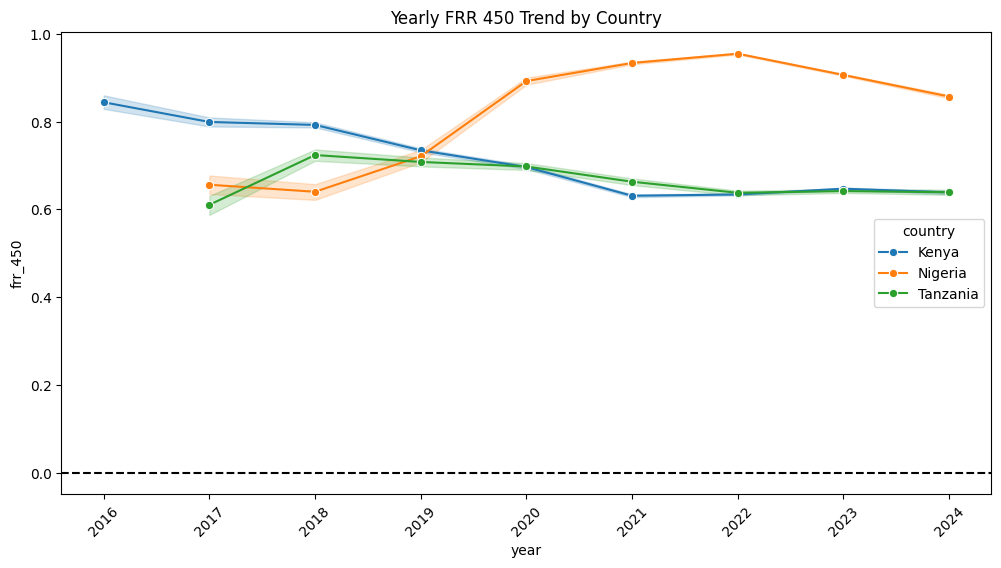

In [104]:
df = df.copy()
df["year"] = df["reg_month"].dt.year
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="year", y="frr_450", hue="country", marker="o")
plt.axhline(0, color="black", linestyle="--")
plt.xticks(rotation=45)
plt.title("Yearly FRR 450 Trend by Country")
plt.show()

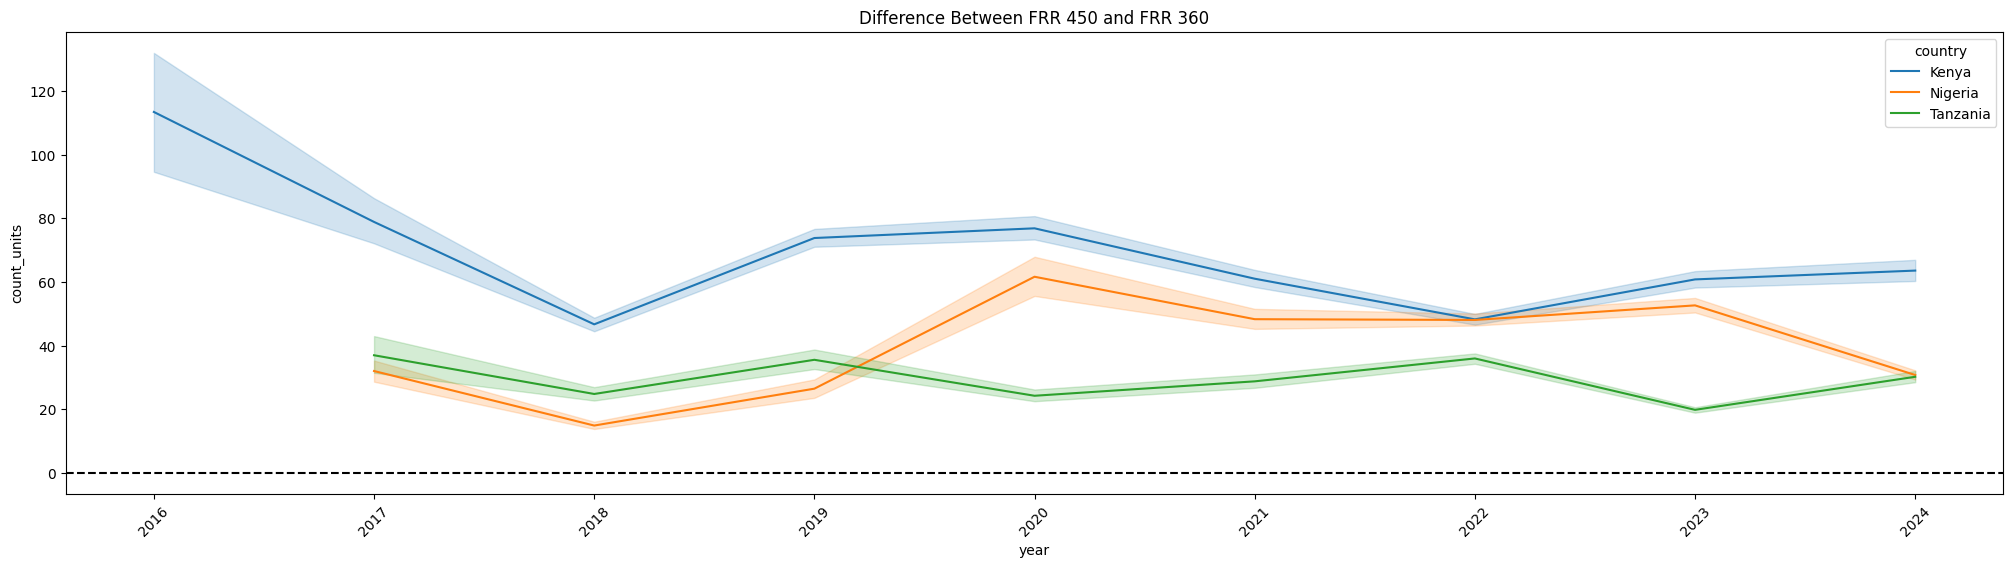

In [108]:
plt.figure(figsize=(25, 6))
sns.lineplot(data=df, x="year", y="count_units", hue="country")
plt.axhline(0, color="black", linestyle="--")
# plt.axvline(pd.to_datetime("2022-02"), color="black", linestyle="--")
# plt.axvline(pd.to_datetime("2021-08"), color="black", linestyle="--")
plt.xticks(rotation=45)
plt.title("Difference Between FRR 450 and FRR 360")
plt.show()

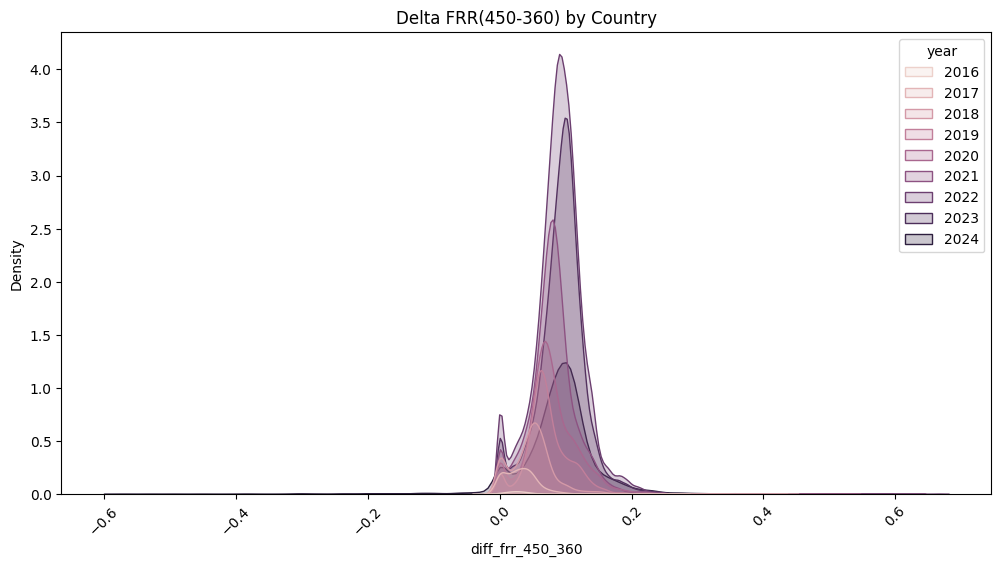

In [109]:
plt.figure(figsize=(12,6))
# sns.boxplot(data=df, x="country", y="diff_frr_450_360")
sns.kdeplot(data=df[df.country=="Kenya"], x="diff_frr_450_360", hue='year', fill=True)
plt.title("Delta FRR(450-360) by Country")
plt.xticks(rotation=45)
plt.show()

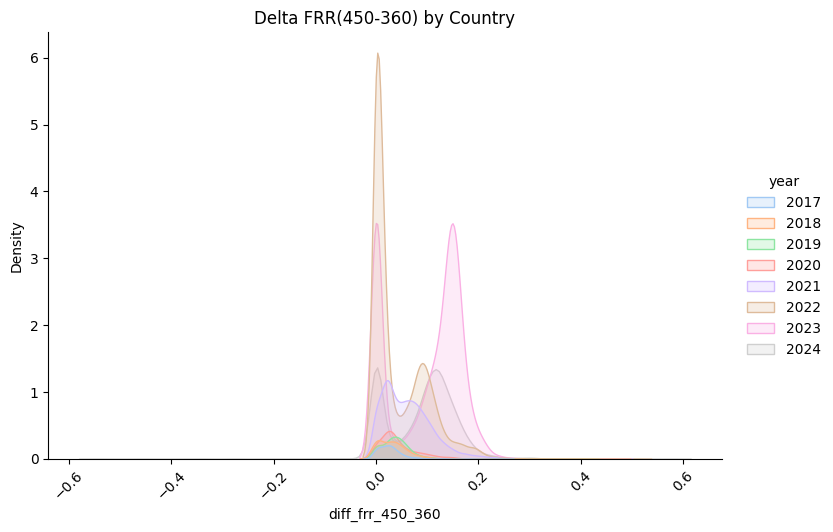

In [117]:
# sns.boxplot(data=df, x="country", y="diff_frr_450_360")
sns.displot(data=df[df.country=="Nigeria"], x="diff_frr_450_360", hue='year', kind="kde", fill=True, \
            palette="pastel", height=5, aspect=1.5)
plt.title("Delta FRR(450-360) by Country")
plt.xticks(rotation=45)
plt.show()

In [118]:
df.accounts_group

1047305    2016-01_Kenya_Lanterns_Kakamega_Sun King Pro E...
1047306    2016-02_Kenya_Lanterns_Bungoma_Sun King Pro Ea...
1047307    2016-02_Kenya_Lanterns_Kakamega_Sun King Pro E...
1047308    2016-03_Kenya_Lanterns_Bungoma_Sun King Pro Ea...
1047309    2016-03_Kenya_Lanterns_Kakamega_Sun King Pro E...
                                 ...                        
1215648    2024-08_Tanzania_SHS without TV_Tarime_Sun Kin...
1215649    2024-08_Tanzania_SHS without TV_Temeke_Sun Kin...
1215650    2024-08_Tanzania_SHS without TV_Unguja_Sun Kin...
1215651    2024-08_Tanzania_SHS without TV_Usa River_Sun ...
1215652    2024-08_Tanzania_SHS without TV_Uyole_Sun King...
Name: accounts_group, Length: 152346, dtype: object

In [119]:
df.reg_month.max()

Timestamp('2024-08-01 00:00:00')

In [120]:
df.reg_month.min()

Timestamp('2016-01-01 00:00:00')

## Target Analysis

In [126]:
df_target = pd.read_csv("Data/cbr_targets.csv000")
df_target.head()

,registration_date_month,country,product_group,area,unit_age_days,primary_product,follow_on_revenue_realization,total_follow_on_revenue_usd
0,2019-03,Kenya,Lanterns,Webuye,1080,Sun King Pro EasyBuy,0.931741,10690.946942
1,2019-03,Kenya,Lanterns,Katito,1080,Sun King Boom EasyBuy,0.948244,11153.405275
2,2019-03,Kenya,SHS Entry-Level,Muhoroni,1080,Sun King Home 120 EasyBuy,0.942182,9303.572262
3,2019-03,Kenya,Lanterns,Mbita,1080,Sun King Pro EasyBuy,0.958868,7589.756226
4,2019-03,Kenya,Lanterns,Kakamega,1080,Sun King Pro EasyBuy,0.921263,10078.869827


In [123]:
df_target.registration_date_month.max()

'2022-10'

In [124]:
df_target.registration_date_month.min()

'2016-01'

In [129]:
df_target['accounts_group'] = df_target['registration_date_month']+'_'+df_target['country']+'_'+ df_target['product_group']+'_'+df_target['area']+'_'+df_target['primary_product']

In [138]:
df_target = df_target[["accounts_group", "follow_on_revenue_realization"]].rename({"follow_on_revenue_realization": "frr_1080"}, axis=1)

In [140]:
merged_df = pd.merge(left=df, right=df_target, on="accounts_group")

<Axes: >

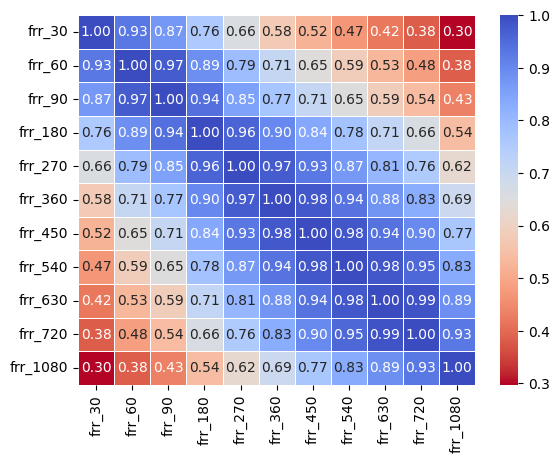

In [142]:
frr_cols = [i for i in merged_df.columns if i.startswith("frr_")]
sns.heatmap(merged_df[merged_df.country=="Kenya"][frr_cols].corr(), annot=True, cmap="coolwarm_r", fmt=".2f", linewidths=0.5)

<Axes: >

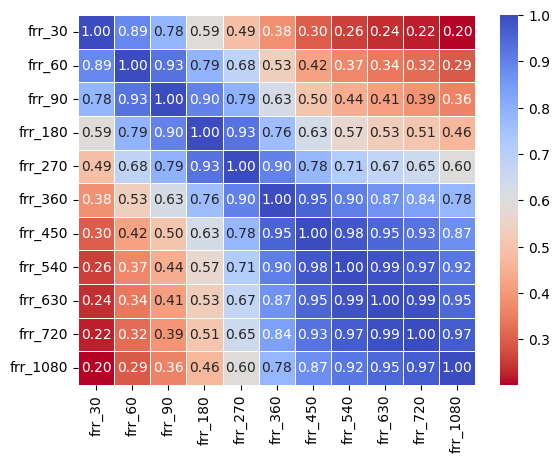

In [143]:
frr_cols = [i for i in merged_df.columns if i.startswith("frr_")]
sns.heatmap(merged_df[merged_df.country=="Nigeria"][frr_cols].corr(), annot=True, cmap="coolwarm_r", fmt=".2f", linewidths=0.5)

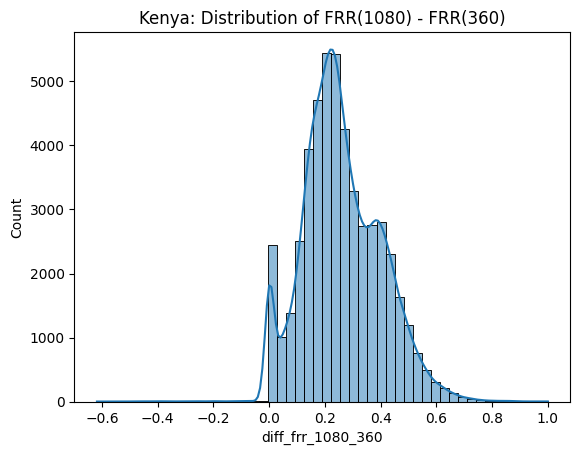

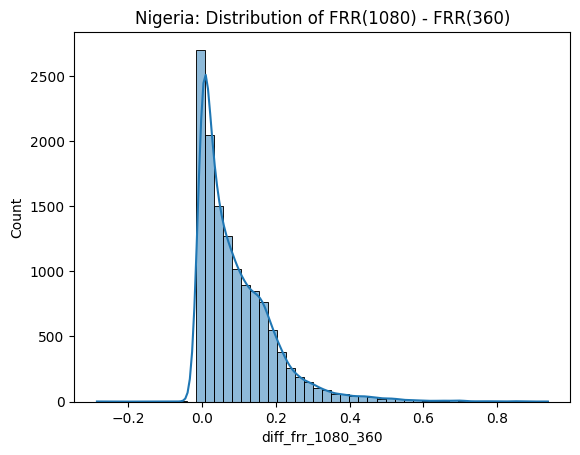

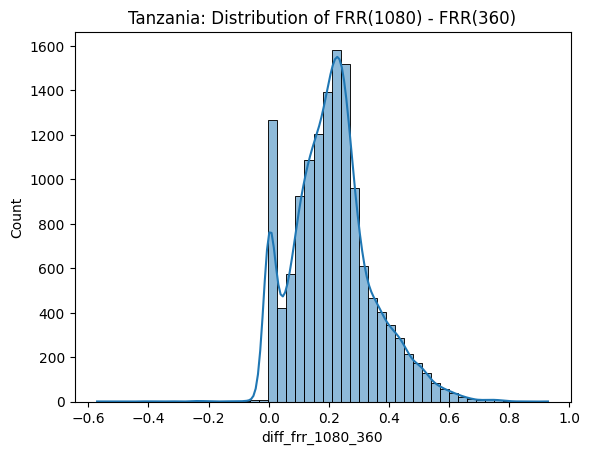

In [145]:
merged_df["diff_frr_1080_360"] = merged_df["frr_1080"] - merged_df["frr_360"]
for country in merged_df.country.unique():
    sns.histplot(merged_df[merged_df.country==country]["diff_frr_1080_360"].dropna(), bins=50, kde=True)
    plt.title(f"{country}: Distribution of FRR(1080) - FRR(360)")
    plt.show()

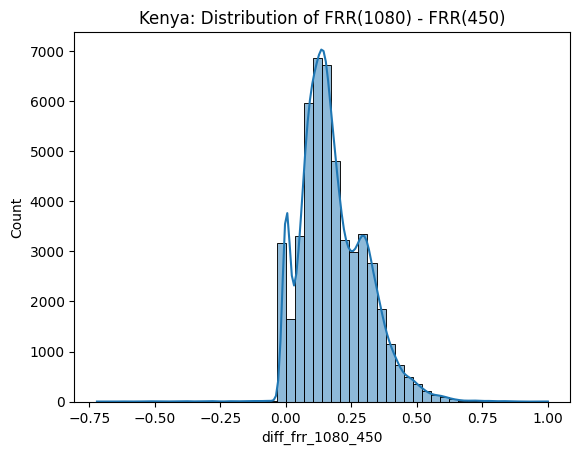

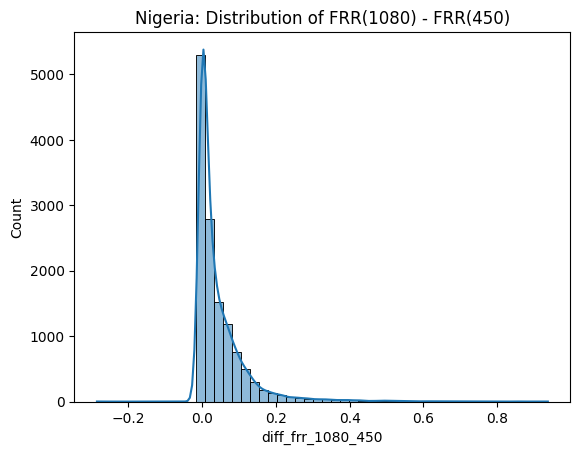

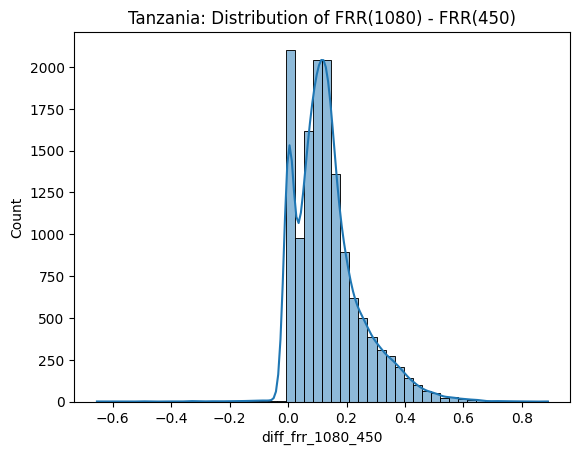

In [146]:
merged_df["diff_frr_1080_450"] = merged_df["frr_1080"] - merged_df["frr_450"]
for country in merged_df.country.unique():
    sns.histplot(merged_df[merged_df.country==country]["diff_frr_1080_450"].dropna(), bins=50, kde=True)
    plt.title(f"{country}: Distribution of FRR(1080) - FRR(450)")
    plt.show()

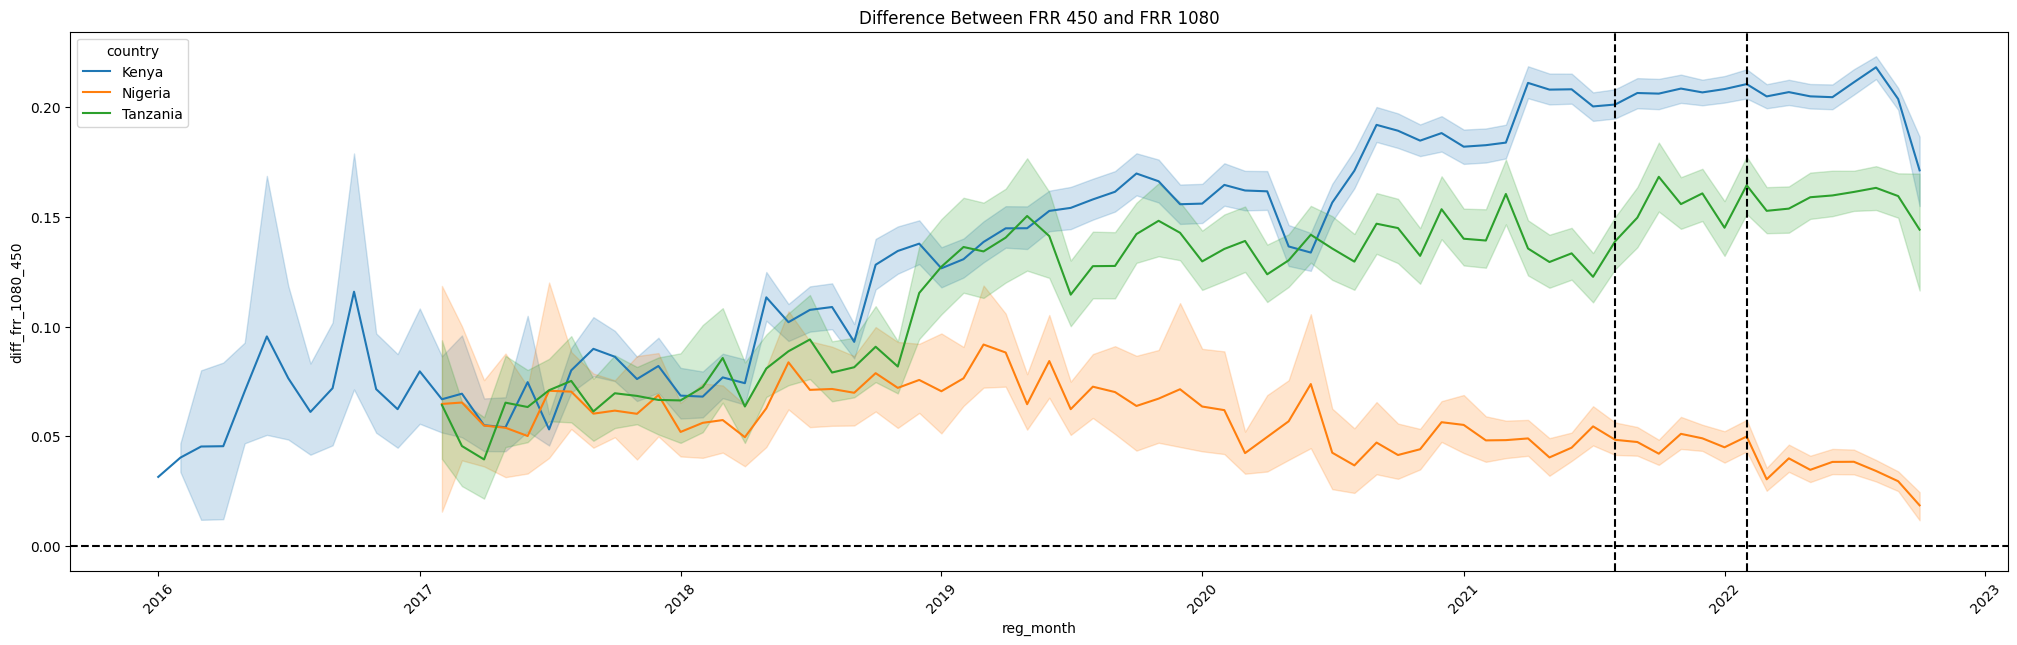

In [148]:
plt.figure(figsize=(25, 7))
sns.lineplot(data=merged_df, x="reg_month", y="diff_frr_1080_450", hue="country")
plt.axhline(0, color="black", linestyle="--")
plt.axvline(pd.to_datetime("2022-02"), color="black", linestyle="--")
plt.axvline(pd.to_datetime("2021-08"), color="black", linestyle="--")
plt.xticks(rotation=45)
plt.title("Difference Between FRR 450 and FRR 1080")
plt.show()

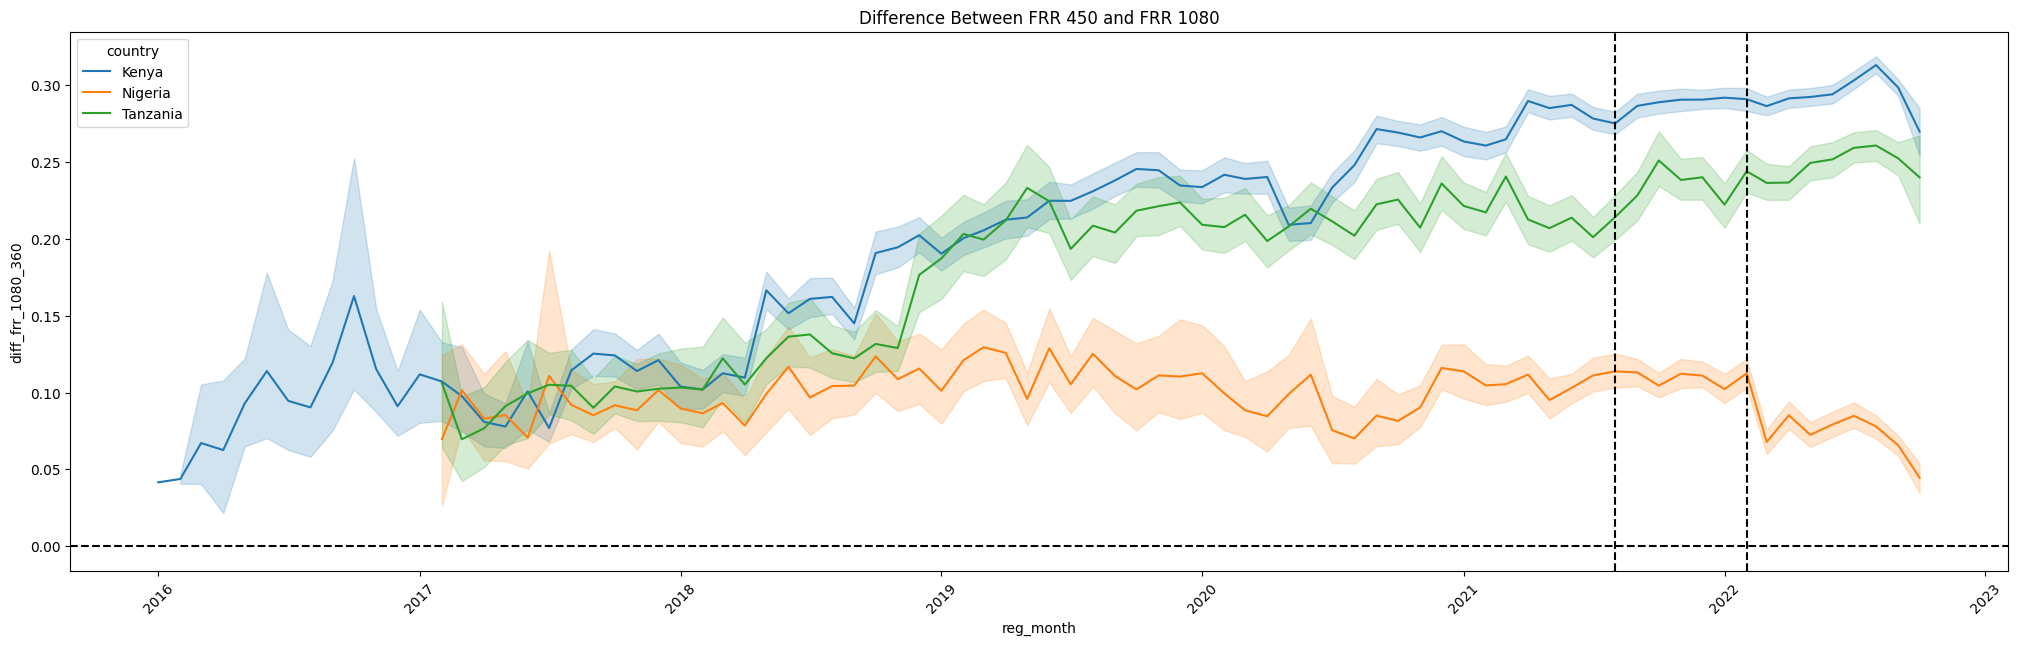

In [ ]:
plt.figure(figsize=(25, 7))
sns.lineplot(data=merged_df, x="reg_month", y="diff_frr_1080_360", hue="country")
plt.axhline(0, color="black", linestyle="--")
plt.axvline(pd.to_datetime("2022-02"), color="black", linestyle="--")
plt.axvline(pd.to_datetime("2021-08"), color="black", linestyle="--")
plt.xticks(rotation=45)
plt.title("Difference Between FRR 1080 and FRR 360")
plt.show()